# Customer Lifetime Value Prediction 

## Define 

Predicting the revenue and customer lifetime value is crucial for any organization not only from Sales Perspective 
but also for supply chain and marketing. Marketing can use these values to optimize the ad spend and supply chain for anticipating future demand. 

Brazillian ecommerce dataset consists of ecommerce data at product/seller level along with few marketing metrics. 
After careful analysis, the marketing metrics had a lot of missing data and therefore haven't been used in this analysis. 
The customer and seller information consists various states/cities. For easier analysis, the metrics haven't been used. 

Objective:
     
Predicting the Customer Lifetime Value at transaction level.



In [69]:
# Import Libraries
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from kmodes import kmodes
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

__author__ = "Sai Jyothi Gurram"
__email__ = "jyothisai1993@gmail.com"

# DISCOVER

### ----2  Load the data ----

In [70]:
product = pd.read_csv('olist_products_dataset.csv')

product dataset consists of product_id's and category names 

In [71]:
product_translation = pd.read_csv('product_category_name_translation.csv')

product translation dataset contains english translation for the portuguese product category names 

In [72]:
orders = pd.read_csv('olist_orders_dataset.csv')

orders dataset consists of the order_id, customer_id and order purchase date 

In [73]:
customer = pd.read_csv('olist_customers_dataset.csv')

customer dataset consists of customer_id and unique customer id 

In [74]:
order_items = pd.read_csv('olist_order_items_dataset.csv')

order items dataset consists of order_id, item_id, product category and revenue 

In [75]:
#merge product with product category translation 
product = product[['product_id','product_category_name']]
product_cat = product.merge(product_translation,on ='product_category_name',how = 'left')
product_cat.drop(['product_category_name'],axis = 1, inplace = True)
product_cat = product_cat.rename(columns = {'product_category_name_english' : 'product_category'})

combining product with product category translation dataset using product category name 

In [76]:
#checking the shape of combined dataframe
product_cat.shape

(32951, 2)

In [77]:
#merging order_items with product_cat 
closed_order_items = order_items.merge(product_cat,on ='product_id',how = 'left')

joining order_items dataset with product_category dataset using product id 

In [78]:
#checking the shape of combined dataframe
closed_order_items.shape

(112650, 8)

In [79]:
#orders
orders = orders[['order_id','customer_id','order_purchase_timestamp']]
orders = orders.set_index('customer_id')
orders.drop_duplicates(inplace=True)

In [80]:
#customer
customer = customer[['customer_id', 'customer_unique_id']]
customer = customer.set_index('customer_id')

In [81]:
#combining customer with orders 
order_customer = pd.concat([orders,customer], axis=1, join='inner')
order_customer.reset_index(inplace=True)

In [82]:
#checking the shape of combined dataframe
order_customer.shape

(99441, 4)

In [114]:
#merging closed_order_items with orders
merged = closed_order_items.merge(order_customer,on ='order_id',how = 'left')

In [84]:
#checking the shape of combined dataframe
merged.shape

(112650, 11)

### ----3  Clean the data ----

In [115]:
#converting all dates into datetimes
merged['shipping_limit_date'] = pd.to_datetime(merged['shipping_limit_date'])
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])

In [116]:
#As our target column is revenue checking for duplicates 
print("Number of duplicated records in training set: ", merged.duplicated().sum())

Number of duplicated records in training set:  0


In [117]:
#checking the datatypes 
merged.dtypes

order_id                            object
order_item_id                        int64
product_id                          object
seller_id                           object
shipping_limit_date         datetime64[ns]
price                              float64
freight_value                      float64
product_category                    object
customer_id                         object
order_purchase_timestamp    datetime64[ns]
customer_unique_id                  object
dtype: object

In [118]:
#checking for null values
merged.isnull().any()

order_id                    False
order_item_id               False
product_id                  False
seller_id                   False
shipping_limit_date         False
price                       False
freight_value               False
product_category             True
customer_id                 False
order_purchase_timestamp    False
customer_unique_id          False
dtype: bool

In [119]:
#checking the count of null values
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 11 columns):
order_id                    112650 non-null object
order_item_id               112650 non-null int64
product_id                  112650 non-null object
seller_id                   112650 non-null object
shipping_limit_date         112650 non-null datetime64[ns]
price                       112650 non-null float64
freight_value               112650 non-null float64
product_category            111023 non-null object
customer_id                 112650 non-null object
order_purchase_timestamp    112650 non-null datetime64[ns]
customer_unique_id          112650 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 10.3+ MB


In [120]:
#replacing null values with other
merged['product_category'] = merged['product_category'].fillna('Other') 

In [121]:
#dropping unnecessary columns
merged.drop(['seller_id','shipping_limit_date','product_id'],axis = 1, inplace = True)

In [122]:
#creating the target revenue column 
merged['Revenue'] = merged['price']+merged['freight_value']

In [123]:
#dropping columns
merged.drop(['price','freight_value'],axis = 1, inplace = True)

### ----4 Explore the data ----

In [124]:
#EDA 
#the number of orders in the datset

merged.shape

#there are 112650 orders

(112650, 7)

In [125]:
#total Revenue 
print ("total Revenue = %2.2f" % merged['Revenue'].sum())

total Revenue = 15843553.24


In [126]:
#analyzing order_purchase date
merged['order_purchase_timestamp'].describe()


count                  112650
unique                  98112
top       2017-07-16 18:19:25
freq                       21
first     2016-09-04 21:15:19
last      2018-09-03 09:06:57
Name: order_purchase_timestamp, dtype: object

data here is for two years from September 2016 until September 2018

In [127]:
#Creating a new column month to simplify the analysis
merged['Month'] = merged['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [128]:
#Excluding 2016 September and 2018 September as data is incomplete
merged = merged[merged['Month'] > 201609]
merged = merged[merged['Month'] < 201809]

In [129]:
merged.shape

(112643, 8)

In [130]:
#analyzing revenue 
merged['Revenue'].describe()

count    112643.000000
mean        140.648172
std         190.729357
min           6.080000
25%          55.225000
50%          92.320000
75%         157.940000
max        6929.310000
Name: Revenue, dtype: float64

Average revenue is 140 while the standard deviation is 190. 

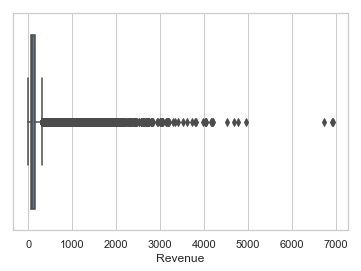

In [131]:
#Creating a boxplot for revenue 
sns.boxplot(x=merged["Revenue"])

In [132]:
#checking the IQR
Q1 = merged['Revenue'].quantile(0.25)
Q3 = merged['Revenue'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

102.715


In [133]:
#checking the data within 1.5*times IQR
print("Less than 1.5 IQR",(merged[merged['Revenue'] < (Q1 - 1.5 * IQR)]).shape)
print("Greater than 1.5 IQR",(merged[merged['Revenue'] > (Q1 + 1.5 * IQR)]).shape)

Less than 1.5 IQR (0, 8)
Greater than 1.5 IQR (16674, 8)


There are 16674 rows that are not in 1.5*IQR range

In [134]:
#Removing outliers 
merged = merged[merged['Revenue'] < (Q1 + 1.5 * IQR)]
merged = merged.reset_index()
merged.shape

(95969, 9)

In [135]:
#creating a new dataframe for analysis 
month = merged.groupby(['Month'])['Revenue'].sum().reset_index()

In [136]:
#creating a scatter plot for Revenue with respect to month 

month_df = [
    go.Scatter(
        x=month['Month'], 
        y=month['Revenue'],
    )
]

scatter_layout = go.Layout(
        xaxis={"type": "category"},
        title='Revenue'
    )
figure = go.Figure(data=month_df, layout=scatter_layout)
pyoff.iplot(figure)

In [137]:
#creating new order_item column 
merged['order_item'] = merged.order_item_id.astype(str) + merged.order_id

In [138]:
#creating monthly active customers 
active = merged.groupby('Month')['customer_unique_id'].nunique().reset_index()

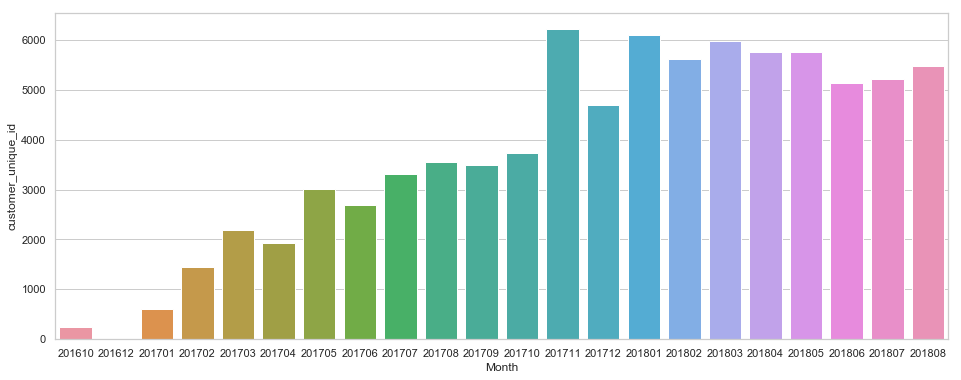

In [139]:
#creating a barplot for distribution 
sns.set(style="whitegrid")
plt.figure(figsize = (16,6))
sns.barplot(x="Month", y="customer_unique_id", data=active)

Monthly unique/new customers have increased from November 2017. We do not know whether there were any promotions or any sales/marketing efforts that aided this growth

In [140]:
#Analyzing new vs existing customers 
#create a dataframe containning unqiue customer id and the first_order_date 
first_purchase = merged.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
first_purchase.columns = ['customer_unique_id','firstpurchasedate']
first_purchase['First_Month'] = first_purchase['firstpurchasedate'].map(lambda date: 100*date.year + date.month)


In [141]:
#merge first purchase date column to our main dataframe 
merged = pd.merge(merged, first_purchase, on='customer_unique_id')
merged.drop(['index'],axis = 1, inplace = True)

,order_id,order_item_id,product_category,customer_id,order_purchase_timestamp,customer_unique_id,Revenue,Month,order_item,firstpurchasedate,First_Month
0,00010242fe8c5a6d1ba2dd792cb16214,1,cool_stuff,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,72.19,201709,100010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,201709
1,00024acbcdf0a6daa1e931b038114c75,1,perfumery,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,25.78,201808,100024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,201808


In [142]:
#assigning new and existing user values 
merged['user_type'] = 'New'
merged.loc[merged['Month']>merged['First_Month'],'user_type'] = 'Existing'

In [143]:
#creting dataframe for user type revenue 
user_type_revenue = merged.groupby(['Month','user_type'])['Revenue'].sum().reset_index()
x =user_type_revenue.query("Month !=201610 and Month != 201612")

In [144]:
#plot the distribution of revenue with respect to usertype 
scatter_data = [
    go.Scatter(
        x= x.loc[x['user_type'] == 'Existing']['Month'],
        y= x.loc[x['user_type'] == 'Existing']['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x= x.loc[x['user_type'] == 'New']['Month'],
        y= x.loc[x['user_type'] == 'New']['Revenue'],
        name = 'New'
    )
]

scatter_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=scatter_data, layout=scatter_layout)
pyoff.iplot(fig)

new customers revenue contribution had a consistent growth while the revenue contribution from existing customers was negligible. 

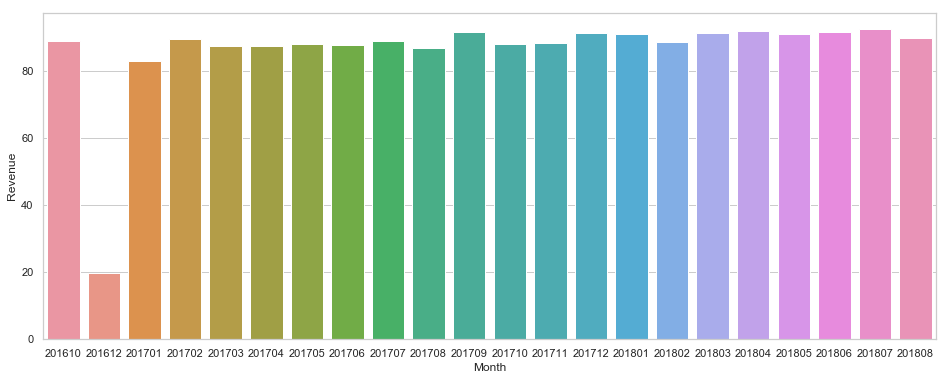

In [145]:
#monthly Avg_revenue per order 
order_avg = merged.groupby('Month')['Revenue'].mean().reset_index()

#creating a barplot for distribution 
sns.set(style="whitegrid")
plt.figure(figsize = (16,6))
sns.barplot(x="Month", y="Revenue", data=order_avg)

Monthly average order size is consistent 

In [146]:
#creating new column for recency 
merged['Recency'] = (merged['order_purchase_timestamp'].max() - merged['order_purchase_timestamp']).dt.days

In [147]:
#Analyzing recency
merged['Recency'].describe()

count    95969.000000
mean       239.549875
std        152.738176
min          0.000000
25%        116.000000
50%        220.000000
75%        349.000000
max        695.000000
Name: Recency, dtype: float64

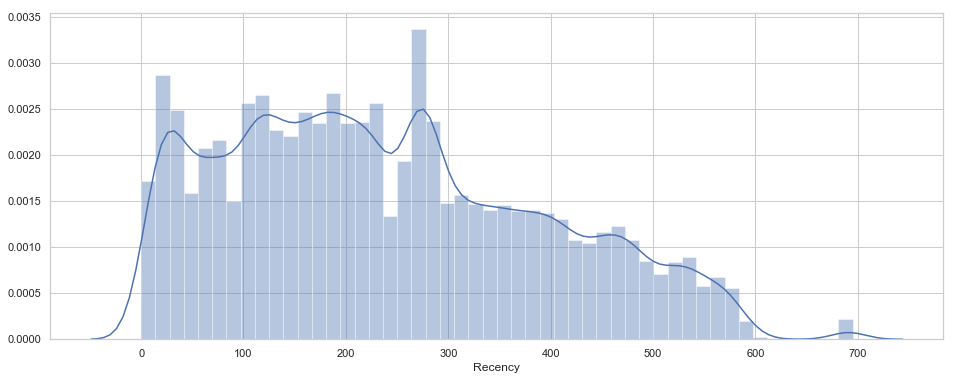

In [148]:
#recency distribution 
sns.set(style="whitegrid")
plt.figure(figsize = (16,6))
sns.distplot(merged['Recency'])


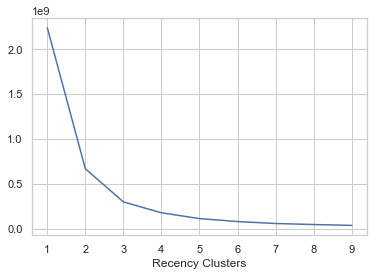

In [253]:
#Creating Recency clusters for better analysis using k-means 
from sklearn.cluster import KMeans
value={}
df_recency = merged[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    value[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(value.keys()), list(value.values()))
plt.xlabel("Recency Clusters")
plt.show()

4 looks like the optimal number of numbers 

In [254]:
#assigning 4 clusters for recency 
kmeans = KMeans(n_clusters=4)
kmeans.fit(merged[['Recency']])
merged['RecencyCluster'] = kmeans.predict(merged[['Recency']])

In [219]:
#Analyzing Clusters 
merged.groupby(['RecencyCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,17254.0,484.022256,59.580103,399.0,436.0,475.0,527.0,695.0
1,27968.0,183.385333,34.977054,123.0,154.0,183.0,214.0,248.0
2,25484.0,61.972179,36.124201,0.0,28.0,62.0,97.0,122.0
3,25263.0,313.890749,43.341408,249.0,276.0,307.0,351.0,398.0


The clusters assigned above aren't ordered appropriately. 

In [222]:
#changing datatype 
merged['RecencyCluster']= pd.Categorical(merged.RecencyCluster)

### ----5  Creating a baseline model ----

In [226]:
#Removing few features
decision_tree = merged.drop(['product_category','Recency','order_item','order_id','order_item_id','customer_id','order_purchase_timestamp','customer_unique_id','Month','First_Month','firstpurchasedate'],axis = 1)

In [227]:
#base model dataframe 
decision_tree.head()

,Revenue,user_type,RecencyCluster
0,72.19,New,3
1,25.78,New,2
2,34.59,New,0
3,31.75,New,3
4,157.60,New,1


In [228]:
#converting all categorical features into numeric
tree = pd.get_dummies(decision_tree,drop_first = True)

In [311]:
#renaming column names according to their properties
tree = tree.rename(columns = {'RecencyCluster_1':'Less_Recent','RecencyCluster_2':'Recent','RecencyCluster_3':'Old'})

In [312]:
# Split Train/Test Set
Tree_train, Tree_test, rev_train, rev_test = train_test_split(tree.drop(["Revenue"], axis=1), tree["Revenue"],random_state=10, test_size=0.25)

In [313]:
# Examine shape of the dataset
Tree_train.shape

(71976, 4)

In [314]:
#fitting a decision tree model
tree_reg = DecisionTreeRegressor(criterion = 'mse' , max_depth=2)
tree_reg.fit(Tree_train,rev_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [315]:
#Compute errors on train model
r1 = rev_train - tree_reg.predict(Tree_train)

In [316]:
#creating a second tree 
# Fit second model
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(Tree_train,r1)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [317]:
#Compute errors on train model
r2 = r1 - tree_reg2.predict(Tree_train)

In [318]:
# Add up the predictions of each tree model, which is our ensemble of two trees
y_pred = sum(tree.predict(Tree_train) for tree in (tree_reg, tree_reg2))

In [319]:
#creating empty dataframe
pred  = pd.DataFrame()

In [320]:
pred['Actual'] = rev_train[:5]

In [321]:
# Create dataframe of all predictions
pred['model_1'] = tree_reg.predict(Tree_train)[:5]
pred['model_2'] = tree_reg2.predict(Tree_train)[:5]
pred['Ensemble'] =y_pred[:5]

# Display predictions
pred

,Actual,model_1,model_2,Ensemble
48173,86.40,88.940870,0.494812,89.435682
12479,46.75,90.896047,-0.117988,90.778060
56644,116.94,88.940870,0.494812,89.435682
70179,25.75,88.940870,0.494812,89.435682
67632,64.03,91.355188,-0.117988,91.237200


In [322]:
#creating a dataframe to observe the error for various tree's
errors = []
for n_estimators in [1,2,3,4,5,6,7,8,9,10]:
    clf = xgb.XGBRegressor(max_depth=2, n_estimators=n_estimators)
    clf.fit(Tree_train, rev_train, verbose=False)
    errors.append(
        {
            'Tree Count': n_estimators,
            'Average Error': np.average(rev_train - clf.predict(Tree_train)),
        })
    
n_estimators_lr = pd.DataFrame(errors).set_index('Tree Count').sort_index()
n_estimators_lr

,Average Error
Tree Count,
1,62.747368
2,43.923944
3,30.747301
4,21.523610
5,15.066795
6,10.546999
7,7.383035
8,5.168241
9,3.617833


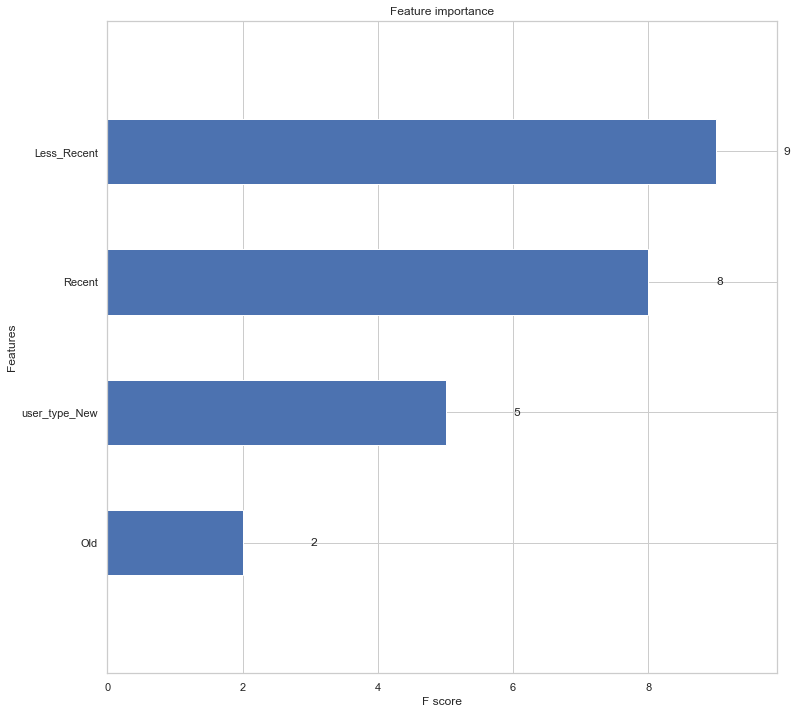

In [323]:
# Plot basic feature importance chart
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(clf, height=0.5, ax=ax)
plt.show()

Clearly as the number of trees increased the average error value decreased 

 ### ----6  Feature Engineering ----

In [256]:
#creating new feature by adding product category frequency to the original dataframe 
merged['category_count'] = merged.groupby(['product_category'])['Revenue'].transform('count')

In [299]:
#Removing few features
data = merged.drop(['product_category','Recency','order_item','order_id','order_item_id','customer_id','order_purchase_timestamp','customer_unique_id','Month','First_Month','firstpurchasedate'],axis = 1)

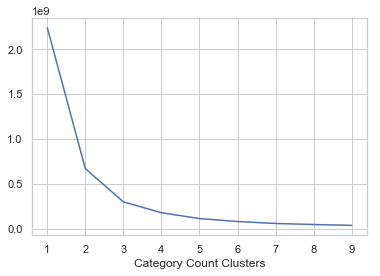

In [293]:
#using k-means to convert the category counts into clusters
value={}
df_count = data[['category_count']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_count["clusters"] = kmeans.labels_
    value[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(value.keys()), list(value.values()))
plt.xlabel("Category Count Clusters")
plt.show()


The optimal k value here is 3

In [300]:
#assigning 3 clusters for category count 
kmeans = KMeans(n_clusters=3)
kmeans.fit(data[['category_count']])
data['product_category'] = kmeans.predict(data[['category_count']])

In [301]:
#Analyzing Clusters 
data.groupby(['product_category'])['category_count'].describe()

,count,mean,std,min,25%,50%,75%,max
product_category,,,,,,,,
0,46422.0,7928.053681,1294.567788,6318.0,6882.0,7527.0,8059.0,10167.0
1,32292.0,3365.096247,662.552735,2341.0,2710.0,3473.0,4113.0,4233.0
2,17255.0,866.165807,625.054188,1.0,295.0,732.0,1467.0,1902.0


In [303]:
#Preprocessing data 
data = data.drop(['category_count'],axis = 1)

In [306]:
#converting datatypes
data.product_category = data.product_category.astype(str)
data.RecencyCluster = data.RecencyCluster.astype(str)

In [308]:
#converting categories into numeric features 
data = pd.get_dummies(data,drop_first = True)

In [324]:
#renaming column names according to their properties
data = data.rename(columns = {'RecencyCluster_1':'Less_Recent','RecencyCluster_2':'Recent','RecencyCluster_3':'Old','product_category_1':'Medium','product_category_2':'Low'})

,Revenue,user_type_New,Less_Recent,Recent,Old,Medium,Low
Revenue,1.000000,0.012020,-0.019755,0.009398,0.017064,-0.021826,0.007568
user_type_New,0.012020,1.000000,0.039583,-0.005463,-0.036149,0.019536,-0.004079
Less_Recent,-0.019755,0.039583,1.000000,-0.300254,-0.281515,-0.017153,0.015812
Recent,0.009398,-0.005463,-0.300254,1.000000,-0.385619,-0.004842,-0.006603
Old,0.017064,-0.036149,-0.281515,-0.385619,1.000000,-0.025115,0.019418
Medium,-0.021826,0.019536,-0.017153,-0.004842,-0.025115,1.000000,-0.333417
Low,0.007568,-0.004079,0.015812,-0.006603,0.019418,-0.333417,1.000000


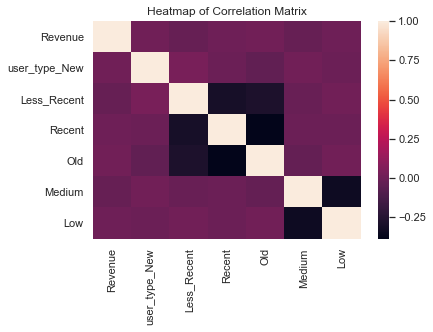

In [326]:
#correlation plot
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

Clearly there is no strong correlation amongst features

### ----7  Creating model ----

In [327]:
#selecting columns 
merged_features = data.drop(['Revenue'],axis = 1)
Revenue = data.Revenue

In [328]:
# Split Train/Test Set
merged_features_train, merged_features_test, Revenue_train, Revenue_test = train_test_split(merged_features, Revenue, test_size=0.25)

In [329]:
#checking the sizes
print(merged_features_train.shape)
print(merged_features_test.shape)
print(Revenue_train.shape)
print(Revenue_test.shape)

(71976, 6)
(23993, 6)
(71976,)
(23993,)


In [330]:
#selecting model 
model = xgb.XGBRegressor()

In [331]:
# Define Parameters
param_grid = {"max_depth": [2,3,5],
              "max_features" : [1.0,0.3,0.1],
              "min_samples_leaf" : [3,5,9],
              "n_estimators": [50,100,150],
              "learning_rate": [0.05,0.1,0.2]}

In [333]:
# Perform Grid Search CV
grid_search = GridSearchCV(model, param_grid=param_grid, cv = 3, verbose=10, n_jobs=-1 ).fit(merged_features_train, Revenue_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3

In [334]:
# Best hyperparmeter setting
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=2, max_features=1.0,
       min_child_weight=1, min_samples_leaf=3, missing=nan,
       monotone_constraints=None, n_estimators=150, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [335]:
#creating an evaluation set 
validation_set = [(merged_features_train,Revenue_train), ( merged_features_test, Revenue_test)]

### ----8  Best model ----

In [336]:
# Use our best model parameters found by GridSearchCV
best_model = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=2, max_features=1.0,
       min_child_weight=1, min_samples_leaf=3, missing=None,
       monotone_constraints=None, n_estimators=150, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [337]:
# Fit our model to the training set
best_model.fit(merged_features_train,Revenue_train, eval_set= validation_set, verbose=False)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=2, max_features=1.0,
       min_child_weight=1, min_samples_leaf=3, missing=nan,
       monotone_constraints=None, n_estimators=150, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

### ----9  Testing model ----

In [338]:
# Make predictions with test data
Revenue_pred = best_model.predict(merged_features_test)
predictions = [round(value) for value in Revenue_pred]

In [339]:
Revenue_test = Revenue_test.reset_index()
actual = Revenue_test['Revenue']

In [340]:
# Retrieve performance metrics
results = best_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)


Text(0.5, 1.0, 'XGBoost RMSE')

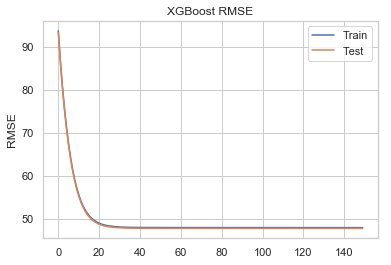

In [341]:
# Plot log loss curve
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')

the logloss curve doesn't show overfitting

In [342]:
#mean sqaured error and Revenue totals 
mse = metrics.mean_squared_error(actual, predictions)
print('mse:',mse)
print('Actual_Revenue:',actual.sum())
print('Predicted_Revenue:',sum(predictions))

mse: 2278.3776892635356
Actual_Revenue: 2149498.27
Predicted_Revenue: 2156111.0


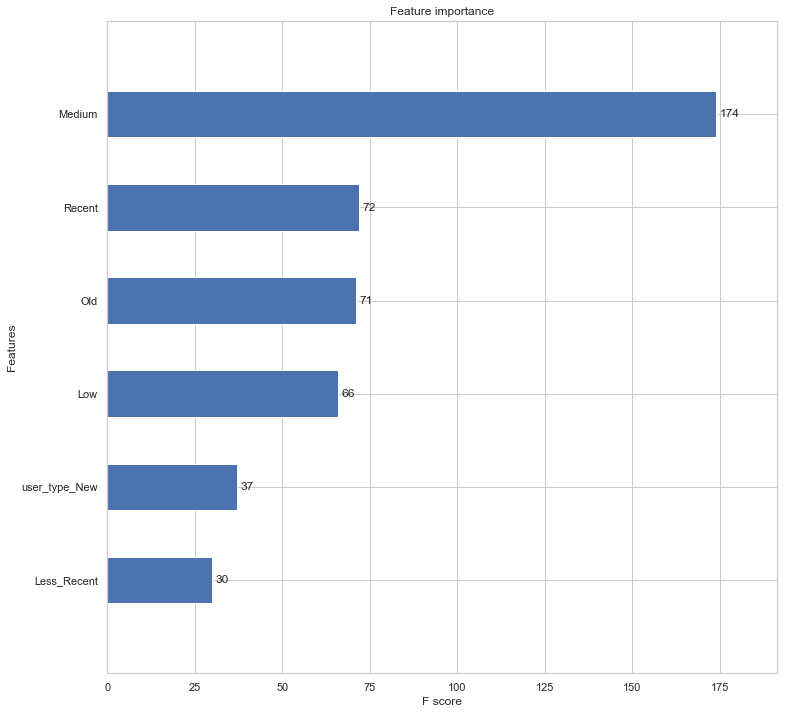

In [343]:
# Plot basic feature importance chart
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(best_model, height=0.5, ax=ax)
plt.show()

### ----10  Summary ----

We can apply this model to future ecommerce metrics and obtain revenue at the transaction level and convert it into customer lifetimevalue. 

As the number of existing customers were less, I haven't included any frequency feature to cluster audience segments.

Improvement:

This model can be improved by adding new features. 

The geographical locations of customers and sellers can determine why customers in few areas are purchasing more compared to the others. 

